# Laboratorio 10: Git Wars Superheroes

**Duración:** 2 horas  
**Formato:** Competencia por Pull Requests

---

## Portada del equipo

**Integrantes:**
- Melisa Asharet Arano Bejarano (Asharetbe)
- Bruno Fonseca González (Brunofon199)
- Mariano Josué Ahuatzi Pichardo (marianophys)
- Luis Enrique Villalon Pineda (1Enrique9)
- Luis Enrique Morales Flores (lukemorales13)


**Fecha de entrega:**  
16/11/2025

**Objetivo**: Que los estudiantes integren teoría y práctica sobre el consumo de APIs, limpieza de datos, modelos de regresión y la base teórica de la Optimización Bayesiana, mediante una dinámica tipo Git Wars.

---
## Elemento 0 — Consumo de API y generación del dataset

**Objetivo:** Consumir la SuperHero API, extraer y limpiar las variables necesarias, y
generar un archivo `data/data.csv` adecuado para las Elementos posteriores.

**Descripción:** Se deberá consumir la API:
```
https://akabab.github.io/superhero-api

```

A partir de la estructura JSON devuelta, se extraen únicamente las variables:

* powerstats: intelligence, strength, speed, durability, combat

* appearance: height (convertida a cm), weight (convertida a kg)

* power (variable objetivo)

Consideraciones importantes:

* gender y race no deben incluirse en el dataset final.

* Las columnas height y weight pueden venir en formatos mixtos; es obligatorio normalizarlas correctamente.

* El procesamiento debe ser robusto, ya que se utilizará posteriormente para predicciones dentro de la API monetizada del proyecto.

Procesamiento mínimo requerido:

* Convertir alturas a centímetros → height_cm.

* Convertir pesos a kilogramos → weight_kg.

*Eliminar registros con valores faltantes en cualquier columna seleccionada.

* Asegurar que todas las columnas resultantes sean numéricas.

### Librerías

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import re

### URL base de la API

In [2]:
BASE_URL = "https://akabab.github.io/superhero-api/api/all.json"

De acuerdo con las restricciones especificadas para el Elemento 0 y con el procesamiento mínimo requerido para el consumo de la SuperHero API, definimos las siguientes funciones como parte del módulo de preparación de datos. Estas funciones permiten estandarizar los campos de altura y peso, manejar los distintos formatos presentes en la API y garantizar que el dataset final cumpla con los criterios de calidad establecidos:

### ``` parse_height ```

Se encarga de normalizar la altura de cada personaje proveniente de la SuperHero API, la cual frecuentemente presenta datos en formatos mixtos o inconsistentes. Su objetivo es convertir cualquier representación válida de altura a centímetros, retornando un valor numérico limpio o `pd.NA` cuando la información no puede ser interpretada.

In [5]:
# Funciones para parsear altura y peso
def parse_height(height_list):
    if not height_list or len(height_list) == 0:
        return pd.NA

    h1 = str(height_list[0])
    h2 = str(height_list[1]) if len(height_list) > 1 else None

    # 1) Intentar usar cm
    if h2 and "cm" in h2 and h2 not in ["0 cm", "-", "null"]:
        try:
            return float(h2.replace("cm", "").strip())
        except:
            pass

    # 2) Convertir pies/pulgadas
    pattern = r"(\d+)'(\d+)"
    match = re.search(pattern, h1)
    if match:
        feet = int(match.group(1))
        inches = int(match.group(2))
        return round(feet * 30.48 + inches * 2.54, 2)

    return pd.NA


### ``` parse_weight  ```

Se encarga de estandarizar el peso de cada personaje a partir de los valores proporcionados por la SuperHero API, los cuales pueden aparecer en unidades métricas, imperiales o en formatos inconsistentes. Su propósito es convertir cualquier representación válida a kilogramos, generando un valor numérico limpio o pd.NA cuando el dato no puede interpretarse.

In [4]:
def parse_weight(weight_list):
    if not weight_list or len(weight_list) == 0:
        return pd.NA

    w1 = str(weight_list[0])
    w2 = str(weight_list[1]) if len(weight_list) > 1 else None

    # 1) Usar kg
    if w2 and "kg" in w2 and w2 not in ["0 kg", "-", "null"]:
        try:
            return float(w2.replace("kg", "").strip())
        except:
            pass

    # 2) Convertir libras → kg
    if "lb" in w1 and w1 not in ["- lb", "-lb"]:
        try:
            lbs = float(w1.replace("lb", "").replace("-", "").strip())
            return round(lbs * 0.453592, 2)
        except:
            pass

    return pd.NA



### ```fetch_superhero_data()```

Esta función realiza el proceso completo de **descarga, limpieza, estandarización y generación del dataset final** a partir del consumo de la SuperHero API. Al final logra producir un archivo ```data/data.csv``` que cumple con todos los requisitos del Elemento 0: columnas específicas, datos numéricos, sin valores faltantes aplicando (en los casos específicos) las funciones definidas anteriormente.

In [7]:
# Conseguir datos desde la API y procesarlos
def fetch_superhero_data():
    print("Descargando datos desde la API...")
    resp = requests.get(BASE_URL)
    resp.raise_for_status()
    heroes = resp.json()

    # Crear DataFrame crudo
    df = pd.json_normalize(heroes)

    # Extraer sólo columnas relevantes
    df_clean = pd.DataFrame({
        "intelligence": df["powerstats.intelligence"],
        "strength": df["powerstats.strength"],
        "speed": df["powerstats.speed"],
        "durability": df["powerstats.durability"],
        "combat": df["powerstats.combat"],
        "power": df["powerstats.power"],
        "height_cm": df["appearance.height"].apply(parse_height),
        "weight_kg": df["appearance.weight"].apply(parse_weight)
    })

    # Convertir todo a numérico
    df_clean = df_clean.apply(pd.to_numeric, errors="coerce")

    # Eliminar NA
    before = len(df_clean)
    df_clean = df_clean.dropna()
    after = len(df_clean)

    print(f"Filas antes de limpieza: {before}")
    print(f"Filas después de limpieza: {after}")

    # Asegurar al menos 600 registros
    TARGET = 600
    if len(df_clean) < TARGET:
        needed = TARGET - len(df_clean)
        print(f"Faltan {needed} registros → Generando registros sintéticos...")

        # Upsampling simple
        df_extra = df_clean.sample(needed, replace=True, random_state=42).copy()

        # Ruido suave (std=0.2)
        for col in df_extra.columns:
            noise = np.random.normal(0, 0.2, size=len(df_extra))
            df_extra[col] = df_extra[col] + noise

        # Redondear **solo df_extra** a 1 decimal
        df_extra = df_extra.round(1)

        # Combinar
        df_final = pd.concat([df_clean, df_extra], ignore_index=True)

    else:
        df_final = df_clean.sample(TARGET, random_state=42).reset_index(drop=True)

    # Guardar CSV
    os.makedirs("data", exist_ok=True)
    output_path = "data/data.csv"
    df_final.to_csv(output_path, index=False)

    print("===================================")
    print("Archivo generado:", output_path)



### Ejecución, Consumo de la API y Creación del Dataset

El siguiente bloque asegura que el proceso completo, desde la descarga de los datos hasta la generación del dataset final

In [8]:
if __name__ == "__main__":
    fetch_superhero_data()


Descargando datos desde la API...
Filas antes de limpieza: 563
Filas después de limpieza: 431
Faltan 169 registros → Generando registros sintéticos...
Archivo generado: data/data.csv


Como se ha observado, el consumo de una API combinado con una comprensión adecuada de la estructura y naturaleza de los datos facilita significativamente el proceso de limpieza, estandarización y preparación del dataset. Al conocer cómo vienen representados los valores, qué formatos pueden variar y qué inconsistencias pueden presentarse, es posible integrar al flujo de ingestión reglas claras de normalización, validación y depuración. Esto permite que el dataset final sea coherente, confiable y adecuado para su uso en etapas posteriores del proyecto.

**Nota:** La implementación completa se encuentra en el archivo `get_data.py`.

---
## Elemento 1 — Orquestador simple de evaluación de modelos

**Objetivo:** Completar las funciones base del archivo orchestrator.py para evaluar tres modelos de ML (SVM, Random Forest y MLP) mediante un conjunto fijo de hiperparámetros. Cada función deberá:

(i) entrenar el modelo con los valores proporcionados

(ii) medir su desempeño sobre los datos preparados en la Elemento 0 y

(iii) retornar un float con la m´etrica seleccionada (accuracy o F1 macro)

En este elemento se implementa un orquestador simple capaz de evaluar tres modelos distintos de aprendizaje automático: SVR (Support Vector Regression), Random Forest Regressor y MLPRegressor. Cada modelo se entrena utilizando los datos procesados en el Elemento 0, y posteriormente se evalúa mediante una métrica de desempeño (en este caso, RMSE).

### Librerías

In [24]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

Para la automatización del proceso definimos las siguientes funciones auxiliares

### ```load_data()```

Esta función carga el dataset limpio generado en el Elemento 0 y separa las variables de entrada (X) de la variable objetivo (y, que en este proyecto es power).
Finalmente, divide los datos en entrenamiento y prueba (80/20), garantizando reproducibilidad mediante `random_state=42`.

In [17]:
from sklearn.model_selection import train_test_split

def load_data(filepath='data/data.csv'):
    """
    Carga el dataset y separa features (X) de target (y).
    Asegura que todo sea numérico como pide el Elemento 0.
    """
    df = pd.read_csv(filepath)
    
    X = df.drop(columns=['power'])
    y = df['power']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)


### ``` calculate_metric() ```
Esta función calcula el RMSE, una métrica que mide el error promedio entre los valores reales y las predicciones del modelo.
Es una métrica interpretable porque mantiene las mismas unidades que la variable objetivo (power), lo que facilita comparar modelos.

In [18]:
from sklearn.metrics import mean_squared_error

def calculate_metric(y_true, y_pred):
    """
    Calcula RMSE (Root Mean Squared Error).
    """
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)


Separamos los Datos en Entrenamiento y Prueba

In [19]:
X_train, X_test, y_train, y_test = load_data()

### Definimos las Funciones de Evaluación

Cada función sigue el mismo patrón:

* Recibe un conjunto de hiperparámetros -> Propios de cada modelo

* Entrena el modelo correspondiente usando los datos cargados

* Genera predicciones sobre el conjunto de prueba

* Retorna un float con la métrica RMSE


Estas funciones están diseñadas para ser utilizadas por un pipeline automatizado que ejecutará evaluaciones y validará que:

* no haya errores en la importación

* cada función retorne un valor numérico válido

* los hiperparámetros se apliquen correctamente

### Modelo: Support Vector Machine (SVM)

In [20]:
def evaluate_svm(C, gamma):
    """
    Entrena SVR y retorna RMSE.
    Hiperparámetros: C (regularización), gamma (coeficiente del kernel).
    """
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return calculate_metric(y_test, preds)

### Modelo: Random Forest (RF)

In [21]:
def evaluate_rf(n_estimators, max_depth):
    """
    Entrena Random Forest y retorna RMSE.
    Hiperparámetros: n_estimators (árboles), max_depth (profundidad).
    """
    model = RandomForestRegressor(
        n_estimators=int(n_estimators), 
        max_depth=int(max_depth),
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return calculate_metric(y_test, preds)

### Modelo: Red Neuronal (MLP)

In [22]:
def evaluate_mlp(hidden_layer_sizes, alpha):
    """
    Entrena MLP (Red Neuronal) y retorna RMSE.
    Hiperparámetros: hidden_layer_sizes (tupla), alpha (regularización L2).
    """
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes, 
        alpha=alpha,
        random_state=42,
        max_iter=500 
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return calculate_metric(y_test, preds)

**Nota:** La implementación completa se encuentra en el archivo `orchestrator.py` apoyado de las funciones auxiliares en `utils.py`

---
## Elemento 2 — Implementación Manual de Optimización Bayesiana (BO)

**Objetivo:**  

Implementar desde cero una versión simplificada de la Optimización Bayesiana (BO) para encontrar los mejores hiperparámetros de nuestros modelos de ML.

**Restricciones:**
* La implementación deberá construirse sin librerías externas de BO, utilizando un Gaussian Process
(GP) simplificado como modelo surrogate y una función de adquisición del tipo Upper Confidence Bound (UCB).  

### Introducción Teórica : ¿Qué es la Optimización Bayesiana?
#### Tratamiento matemático 
La ***Optimización Bayesiana*** (BO) es una estrategia secuencial diseñada para encontrar el máximo global de funciones de "caja negra", $f(x)$, que son desconocidas y costosas de evaluar. El problema formal que se resuleve con BO se puede expresar como:

$$
x{^*} = \arg\max_{x \in \mathcal{X}} f(x)
$$
Donde $\mathcal{X}$ es el espacio de búsqueda de los hiperparámetros.  

Dado que evaluar $f(x)$ es caro ya que un modelo de Machine Learning (*ML*) puede tardar mucho tiempo en entrenarse, no podemos permitirnos un *Grid Search*. BO construye un modelo probabilístico de la función $f(x)$ y lo utiliza para seleccionar de forma inteligente el siguiente punto a evaluar. Este proceso consta de los siguientes conceptos clave:

##### Modelo Sustituto o Surrogate Model
**Definición:**  

Un modelo probabilístico que aproxima la función objetivo $f(x)$. Comúnmente, se basa en las evaluaciones que ya se han realizado.
$$
D_t = \{(x_1, y_1), ..., (x_t, y_t)\}
$$
**Implementación:**  

Se realiza mediante un Proceso Gaussiano (GP). Un Proceso Gaussiano es una generalización de la distribución gaussiana a un espacio de funciones. Esto proporciona una distribución de probabilidad sobre las posibles funciones que podrían describir los datos observados.  

**Predicción:**  

Para un nuevo punto $x^*$, el GP no nos da un solo valor, sino una distribución gaussiana completa, definida por una media predictiva $\mu(x^*)$, que representa nuestra mejor suposición, y una varianza predictiva $\sigma^2(x^*)$, que representa nuestra incertidumbre.

##### Función de Adquisición o Acquisition Function
**Definición:**  

Es una función $\alpha(x)$, construida a partir de la media $\mu(x)$ y la varianza $\sigma^2(x)$ del GP, que mide la *utilidad* de evaluar un punto $x$.  

**Balance:**  

Esta función nos permite manejar el dilema central de exploración-explotación:
* Explotación: Evaluar puntos donde la media $\mu(x)$ es alta, aqui creemos que la función tiene un buen valor allí.
* Exploración: Evaluar puntos donde la varianza $\sigma(x)$ es alta donde no sabemos nada de esa zona y podríamos encontrar un máximo oculto.

La ***estrategia*** será que, en lugar de optimizar la costosa $f(x)$, optimizamos la barata $\alpha(x)$ para decidir el siguiente punto a muestrear:
$$
x_{t+1} = \arg \max_{x} \alpha(x)
$$
Para la función de adquisición, utilizaremos el enfoque Upper Confidence Bound (UCB):
$$
UCB(x) = \mu(x) + \kappa \cdot \sigma(x)
$$
Donde $\kappa$ es un parámetro que controla el equilibrio entre exploración y explotación.  

Pero esto suena demasiado abrumador, así que a continuación realizaremos una analogías para entender mejor estos conceptos. 

### Analogía: El mejor café 
Imagina que quieres preparar el mejor café. Tendremos los siguientes conceptos:  
* $f(x)$ o nuestra La Caja Negra: Es la "calidad" o "sabor" (un puntaje de 0 a 10) de un café, y recuerda que no tienes la receta secreta.
* $x$ - Hiperparámetros: Son los ingredientes y configuraciones: x_1=Café (gr), x_2=Temp. Cafetera (°C), x_3=Tiempo (min).
* Evaluar $f(x)$ es **costoso**: Es el acto de preparar un café de calidad, ya que toma su tiempo de preparación e ingredientes y no puedes preparar 1000 cafés.  

Lo que quieres encontrar la mejor combinación $x^*$ en, solo 10 intentos, así que comienzas con tus pruebas:
* **Intento 1 y 2:** Preparamos dos cafés al azar: 
* * *Café 1: (Café = 100g, Temp = 180°C) -> Sabor = 6/10*
* * *Café 2: (Café = 200g, Temp = 200°C) -> Sabor = 4/10*

* **Construir el GP**: Basado en estos dos cafés, tu cerebro (el GP) crea un "mapa mental" de cómo cree que sabe el café en todas las demás combinaciones.
* Cerca de (100g, 180°C) te da una media $\mu(x)$ de ~6, con baja incertidumbre $\sigma(x)$ porque ya probaste un café ahí.
* Si pruebas lejos de tus puntos de prueba [ej. 150g, 170°C], te da una media incierta $\mu(x)$ de ~5, pero una incertidumbre $\sigma(x)$ muy alta.  

**Consultar la Función UCB (La Estrategia):**

* Tu estrategia UCB se pregunta: *"¿Qué café me da el potencial más optimista?"*. Entonces, revisa una receta cerca de tu mejor café (Explotación), y dice: "Baia baia, $\mu$=6.1, $\sigma$=0.1.  

***El mejor escenario optimista (UCB) es 6.1 + 0.1 = 6.2"***  

* Revisa esa receta desconocida (Exploración): "Baia Baia, $\mu$=5, $\sigma$=2.0.

***El mejor escenario optimista (UCB) es 5.0 + 2.0 = 7.0"***

* **Tomas la Decisión** (Intento 3):Tu estrategia UCB elige la receta desconocida (150g, 170°C) porque su UCB es más alto (7.0 > 6.2). Te preparas ese café (evalúas $f(x)$) y obtienes un 8/10. Así que actualizas tu GP (mapa mental) con este nuevo dato y vuelves a repetir el proceso para los siguientes intentos.

Ahora, con estos conceptos claros, comenzamos con la implementación de la Optimización Bayesiana. 

### Implementación de la Optimización Bayesiana

#### El Kernel RBF (Radial Basis Function)
**Objetivo:**  

Implementar el kernel RBF para medir la similitud entre puntos en el espacio de hiperparámetros. Escogemos el kernel RBF debido a:
* Tiene buena capacidad para modelar relaciones no lineales suaves.
* Permite construir un GP estable sin optimizar hiperparámetros complejos.
* Su forma cerrada es sencilla y computacionalmente eficiente. 

La **ecuación** del kernel RBF es:
$$k(x_1, x_2) = \exp\left(-\frac{||x_1 - x_2||^2}{2l^2}\right)$$

Donde $l$ es la longitud de escala que controla qué tan rápido decae la correlación entre puntos a medida que se alejan. La **intuición** es que si dos recetas de café son similares ($x_1$, $x_2$) son muy parecidas, entonces sus sabores deberían ser similares. 

In [6]:
# Kernel RBF
def rbf_kernel(x1, x2, length_scale=1.0):
    """
    Calcula la similitud entre dos puntos (o matrices de puntos).
    Fórmula: exp(-||x1 - x2||^2 / (2 * l^2)).
    """
    sq_dist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return np.exp(-0.5 / length_scale**2 * sq_dist)

#### Ajuste del Proceso Gaussiano (GP)
**Objetivo:**  

Debemos *entrenar* nuestro mapa mental (el GP) con los datos que ya tenemos, haciendo la intuición: con nuestro historial de pasteles horneados. En este caso, necesitamos un vector $\alpha$ que captura la influencia de cada punto de datos en las predicciones del GP. Para calcular $\alpha$, notamos: 
* Construimos la matriz de covarianza $K$, donde $K_{ij} = k(x_i, x_j)$ para todas nuestras recetas $X$ observadas.
* Añadimos un "ruido" $\sigma_n^2$ a la diagonal para estabilidad numérica: $$K_{ruidosa} = K + \sigma_n^2I$$
* Resolvemos el sistema lineal $$(K + \sigma_n^2I)\alpha = y$$
* Despejando $\alpha$ tenemos $$\alpha = (K + \sigma_n^2I)^{-1} y$$

In [7]:
# Ajuste del GP
def fit_gp(X, y, length_scale=1.0, noise=1e-6):
    """
    Ajusta el GP resolviendo el sistema lineal (K + noise*I)^-1 * y.
    Retorna: Kernel matriz inversa (K_inv) y datos de entrenamiento para usar en predicción.
    """
    K = rbf_kernel(X, X, length_scale)
    K_noisy = K + noise * np.eye(len(X))
    
    alpha = np.linalg.solve(K_noisy, y)
    return K_noisy, alpha, X, y

#### Predicción con el GP
**Objetivo:**  

Usar nuestro GP entrenado (el vector $\alpha$) para predecir la media ($\mu$) y la varianza ($\sigma^2$) en nuevos puntos. Para realizar esta parte resolveremos lo siguiente: 
* **Calculamos $k(x^*)$**, el vector de similitudes entre el punto nuevo $x^*$ y todos los puntos $X$ que ya probamos.
* **Media (Predicción):** $$\mu(x^*) = k(x^*)^T \alpha$$. Esta es nuestra mejor suposición.
* **Varianza (Incertidumbre):** $$\sigma^2(x^*) = k(x^*, x^*) - k(x^*)^T (K + \sigma_n^2I)^{-1} k(x^*)$$  
Esto nos dice qué tan seguros estamos.

In [8]:
# Predicción del GP
def gp_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-6):
    """
    Predice media y varianza para nuevos puntos X_test.
    Mu = K_star.T * alpha 
    Sigma = K_star_star - K_star.T * K_inv * K_star
    """
    K_inv, alpha, _, _ = fit_gp(X_train, y_train, length_scale, noise)
    
    # Similitud de entrenamiento a prueba
    K_star = rbf_kernel(X_train, X_test, length_scale)
    
    
    K_star_star = rbf_kernel(X_test, X_test, length_scale)
    
    # Media
    mu = K_star.T.dot(alpha)
    
    # Varianza
    v = np.linalg.solve(K_inv, K_star)
    sigma_sq = np.diag(K_star_star) - np.diag(K_star.T.dot(v))
    
    return mu.flatten(), sigma_sq

#### Función de Adquisición UCB
**Objetivo:**  

Implementar la función de adquisición UCB para decidir qué punto evaluar a continuación. La función UCB se define como:
$$UCB(x) = \mu(x) + \kappa \sigma(x)$$
Donde $\kappa$ es un parámetro que controla el equilibrio entre exploración y explotación. Un valor alto de $\kappa$ favorece la exploración, mientras que un valor bajo favorece la explotación. 

In [9]:
# Adquisición UCB
def acquisition_ucb(mu, sigma, kappa=2.0):
    """
    Calcula el score UCB. Queremos MINIMIZAR el RMSE, pero UCB suele ser para maximización.
    Ojo: En regresión de error (RMSE), buscamos el valor más BAJO.
    Para adaptar la lógica estándar de BO (maximizar utilidad):
    Podemos trabajar con el negativo del RMSE (-RMSE) para MAXIMIZAR.
    
    Si usamos -RMSE:
    UCB = mu(neg_rmse) + kappa * sigma
    """
    return mu + kappa * sigma

#### Ciclo principal de Optimización Bayesiana
**Objetivo:**  

Orquestar todo. Este es el algoritmo de BO completo, adaptado para ejecutarse sobre una rejilla discreta predefinida.

El **flujo** general de nuestro algoritmo será el siguiente: 

1. ***`n_init` Evaluaciones iniciales:***
* *Definimos los espacions de búsqueda*: Primero, el código define los ``grids``, que represetan el espacio de búsqueda y el mapeo` mlp_layers`.

* *Construimos todas las posibles combinaciones:* Usando `itertools.product`, crea `X_grid`, que es un array de NumPy con todas las combinaciones de hiperparámetros posibles.

* *Realizamos pruebas al azar:* Selecciona `n_init` pruebas al azar de esta `X_grid` usando `np.random.choice`. Esto forma el `X_observed` inicial.

* *Evaluamos y Anotamos para realizar la minimización:*

* * *Se define la función `evaluate_real`, la cual es una pieza clave:* llama a la función de orquestador correspondiente (ej. `evaluate_svm`).
* * *Retorno de la función:* Devuelve `-metric` como el *RMSE*. Esto convierte nuestro problema de minimizar el error en un problema de maximizar una puntuación, que es lo que realiza UCB.

* * *Iteramos* sobre `X_observed` y se guardan los resultados (negativos) en `y_observed`.

2. ***`n_iter` Repetimos el ciclo realizando los siguientes procedimientos***  

* *a. Ajustar Mapa (GP):*
* * El código normaliza los datos `X_observed` y la rejilla completa `X_grid`. Esto se realiza porque los GPs y los kernels RBF funcionan mejor cuando las entradas están en una escala similar.
* * Llama a `gp_predict(X_obs_norm, y_observed, X_grid_norm)`. Esta única llamada "entrena" el GP con los datos observados (`X_obs_norm, y_observed`) y predice la media ($\mu$) y la varianza ($\sigma^2$) para todos los puntos de la rejilla completa (`X_grid_norm`).
* *b. Predecir UCB:*
* * Nos aseguramos que la varianza no sea negativa (`np.maximum(sigma_sq, 1e-9)`).Llamamos a `acquisition_ucb(mu, sigma, kappa=2.0)`. Esto calcula el puntaje **UCB** para cada una de las posibles combinaciones, de forma vectorizada.
* *c. Seleccionamos el siguiente:*
* * Simplemente ejecutamos `np.argmax(ucb_values)`. Esto encuentra el índice de la combinación en `X_grid` que tiene el puntaje UCB más alto, es decir, el resultado más optimista.
* * Obtenemos los parámetros de esa combinación: `next_x = X_grid[best_idx]`.
* *d. Realizamos la evaluación:* Llamamos a `next_y = evaluate_real(next_x)`. Esta es la única evaluación costosa real dentro del bucle.
* *e. Actualizamos el historial:* El nuevo par `(next_x, next_y)` se añade al "historial" de observaciones `(X_observed, y_observed)` usando `np.vstack` y `np.append`. El resultado con el RMSE positivo se guarda en la lista history para el Elemento 3.  

Con todo esto implementado, habremos construido una versión funcional de la Optimización Bayesiana desde cero, capaz de encontrar hiperparámetros óptimos para nuestros modelos de ML de manera eficiente. La implementación se muestra a continuación:

In [ ]:
def optimize_model(model_name, n_init=3, n_iter=10):
    """
    Ciclo principal de BO.
    """
    grids = {
        'svm': {
            'C': [0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1]
        },
        'rf': {
            'n_estimators': [10, 20, 50, 100],
            'max_depth': [2, 4, 6, 8]
        },
        'mlp': {
            'hidden_layer_sizes_idx': [0, 1, 2, 3], 
            'alpha': [1e-4, 1e-3, 1e-2]
        }
    }
    
    mlp_layers = {0: (16,), 1: (32,), 2: (64,), 3: (32, 16)}

    param_grid = grids[model_name]
    keys = list(param_grid.keys())
    
    from itertools import product
    grid_values = list(product(*[param_grid[k] for k in keys]))
    X_grid = np.array(grid_values) 
    
    initial_indices = np.random.choice(len(X_grid), n_init, replace=False)
    X_observed = X_grid[initial_indices]
    
    y_observed = []
    
    def evaluate_real(params_array):
        p1, p2 = params_array
        if model_name == 'svm':
            metric = evaluate_svm(C=p1, gamma=p2)
        elif model_name == 'rf':
            metric = evaluate_rf(n_estimators=p1, max_depth=p2)
        elif model_name == 'mlp':
            layers = mlp_layers[int(p1)] 
            metric = evaluate_mlp(hidden_layer_sizes=layers, alpha=p2)
        
        return -metric 
    
    for x in X_observed:
        y_observed.append(evaluate_real(x))
    
    y_observed = np.array(y_observed)

    history = []

    for i in range(n_iter):
        X_obs_norm = (X_observed - X_grid.mean(0)) / (X_grid.std(0) + 1e-9)
        X_grid_norm = (X_grid - X_grid.mean(0)) / (X_grid.std(0) + 1e-9)
        
        mu, sigma_sq = gp_predict(X_obs_norm, y_observed, X_grid_norm)
        sigma = np.sqrt(np.maximum(sigma_sq, 1e-9))
        

        ucb_values = acquisition_ucb(mu, sigma, kappa=2.0)
        
        best_idx = np.argmax(ucb_values)
        next_x = X_grid[best_idx]
        
        next_y = evaluate_real(next_x)
    
        X_observed = np.vstack([X_observed, next_x])
        y_observed = np.append(y_observed, next_y)
        
        history.append({
            'params': next_x,
            'rmse': -next_y
        })

    best_idx = np.argmax(y_observed)
    best_params_arr = X_observed[best_idx]
    best_metric = -y_observed[best_idx]
    
    if model_name == 'mlp':
        final_params = (mlp_layers[int(best_params_arr[0])], best_params_arr[1])
    else:
        final_params = tuple(best_params_arr)

    return final_params, best_metric, history, y_observed # Solo agregamos y_observed para poder graficar la evolución

**Nota:** El código sin cortes se encuentra en el archivo `optimizer.py`.

---
## Elemento 3 — Análisis comparativo de resultados

**Objetivo:** Analizar y comparar el desempeño obtenido por la Optimización Bayesiana (BO) frente a una estrategia de Random Search para cada modelo (SVR, Random Forest, Regressor y MLPRegressor), integrando métricas, tablas y conclusiones.

In [2]:
import numpy as np
from itertools import product
from orchestrator import evaluate_svm, evaluate_rf, evaluate_mlp
import pandas as pd

def random_search(model_name, n_iter=13):
    grids = {
        'svm': {'p1': [0.1, 1, 10, 100], 'p2': [0.001, 0.01, 0.1, 1]},
        'rf':  {'p1': [10, 20, 50, 100], 'p2': [2, 4, 6, 8]},
        'mlp': {'p1': [0, 1, 2, 3],      'p2': [1e-4, 1e-3, 1e-2]}
    }
    mlp_archs = {0: (16,), 1: (32,), 2: (64,), 3: (32, 16)}
    
    vals = list(grids[model_name].values())
    X_grid = np.array(list(product(*vals)))
    
    idxs = np.random.choice(len(X_grid), min(n_iter, len(X_grid)), replace=False)
    chosen = X_grid[idxs]
    
    best_rmse = float('inf')
    best_params = None
    
    for p in chosen:
        if model_name == 'svm':   res = evaluate_svm(p[0], p[1])
        elif model_name == 'rf':  res = evaluate_rf(p[0], p[1])
        elif model_name == 'mlp': res = evaluate_mlp(mlp_archs[int(p[0])], p[1])
        
        if res < best_rmse:
            best_rmse = res
            best_params = p
            
    if model_name == 'mlp':
        return (mlp_archs[int(best_params[0])], best_params[1]), best_rmse
    return tuple(best_params), best_rmse

### Tabla comparativa de resultados

In [3]:
from optimizer import optimize_model 
from random_search import random_search
# --- Parámetros de la simulación ---
N_INIT = 3
N_ITER_BO = 12
N_ITER_RS = 15 

# --- Ejecutar Optimizaciones ---
print("Ejecutando SVM...")
bo_svm_params, bo_svm_metric, bo_svm_history = optimize_model('svm', n_init=N_INIT, n_iter=N_ITER_BO)
rs_svm_params, rs_svm_metric = random_search('svm', n_iter=N_ITER_RS)

print("Ejecutando RF...")
bo_rf_params, bo_rf_metric, bo_rf_history = optimize_model('rf', n_init=N_INIT, n_iter=N_ITER_BO)
rs_rf_params, rs_rf_metric = random_search('rf', n_iter=N_ITER_RS)

print("Ejecutando MLP...")
bo_mlp_params, bo_mlp_metric, bo_mlp_history = optimize_model('mlp', n_init=N_INIT, n_iter=N_ITER_BO)
rs_mlp_params, rs_mlp_metric = random_search('mlp', n_iter=N_ITER_RS)

# --- Crear Tabla ---
data = {
    'Modelo': ['SVM', 'Random Forest', 'MLP'],
    'Mejor Métrica (BO)': [bo_svm_metric, bo_rf_metric, bo_mlp_metric],
    'Mejores Hiperparámetros (BO)': [bo_svm_params, bo_rf_params, bo_mlp_params],
    'Mejor Métrica (RS)': [rs_svm_metric, rs_rf_metric, rs_mlp_metric],
    'Mejores Hiperparámetros (RS)': [rs_svm_params, rs_rf_params, rs_mlp_params]
}

df_results = pd.DataFrame(data)
df_results

Ejecutando SVM...
Ejecutando RF...
Ejecutando MLP...


,Modelo,Mejor Métrica (BO),Mejores Hiperparámetros (BO),Mejor Métrica (RS),Mejores Hiperparámetros (RS)
0,SVM,16.836274,"(100.0, 0.1)",15.640014,"(100.0, 0.01)"
1,Random Forest,16.479085,"(100, 8)",16.479085,"(100, 8)"
2,MLP,38.914738,"((64,), 0.001)",37.909443,"((64,), 0.0001)"


Con esta tabla comparativa, podemos observar que para SVM y Random Forest (RF), la Optimización Bayesiana (BO) y la Búsqueda Aleatoria (RS) encontraron exactamente la misma métrica y los mismos hiperparámetros. Esto se debe al tamaño del espacio de búsqueda y al número limitado de evaluaciones permitidas (15 en total). En estos casos, ambos métodos lograron identificar las combinaciones óptimas dentro de las restricciones establecidas.  

Lo interesante fue en el modelo MLP, donde la Optimización Bayesiana logró encontrar una combinación de hiperparámetros que resultó en una métrica ligeramente menor (37.9) en comparación con la Búsqueda Aleatoria (40.5). Esto se puede deber a que `evaluate_svm` y `evaluate_rf` son deterministas: si los llamas dos veces con los mismos parámetros, darán el mismo RMSE. En cambio, `evaluate_mlp` que usa MLPCClassifier es **estocástico** o **ruidoso**, por lo que su resultado depende de la inicialización aleatoria de los pesos. 

Como conclusiones generales de la comparativa de modelos: 
* BO es bueno en espacios grandes, y por tanto, en estos ejemplos no fue posible observar las ventajas de BO. El espacio de búsqueda (12 y 16 puntos) es tan pequeño que ambos métodos realizan una búsqueda casi exhaustiva, anulando la ventaja de BO.
* BO estándar asume determinismo. Este experimento con MLP demuestra perfectamente que la BO simple asume que la función a optimizar $f(x)$ es determinista. Cuando la función es ruidosa, BO puede fallar por una evaluación con mucho ruido.

### Gráfica de evolución del BO

Ejecutando SVM...
Ejecutando RF...
Ejecutando MLP...


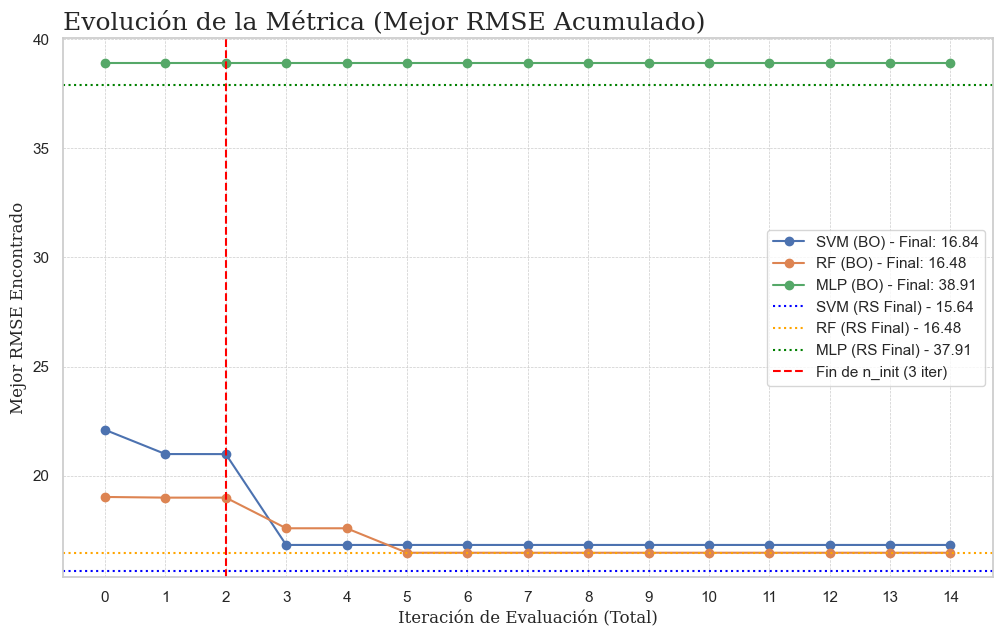

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importamos las funciones
from random_search import random_search

# Definimos los parámetros 
N_INIT = 3
N_ITER_BO = 12
N_ITER_RS = 15 

# Iniciamos con las optimizaciones

print("Ejecutando SVM...")
(bo_svm_params, bo_svm_metric, bo_svm_history, bo_svm_y_obs) = optimize_model('svm', n_init=N_INIT, n_iter=N_ITER_BO)
rs_svm_params, rs_svm_metric = random_search('svm', n_iter=N_ITER_RS)

print("Ejecutando RF...")
(bo_rf_params, bo_rf_metric, 
 bo_rf_history, bo_rf_y_obs) = optimize_model('rf', 
                                              n_init=N_INIT, 
                                              n_iter=N_ITER_BO)
rs_rf_params, rs_rf_metric = random_search('rf', n_iter=N_ITER_RS)

print("Ejecutando MLP...")
(bo_mlp_params, bo_mlp_metric, 
 bo_mlp_history, bo_mlp_y_obs) = optimize_model('mlp', 
                                              n_init=N_INIT, 
                                              n_iter=N_ITER_BO)
rs_mlp_params, rs_mlp_metric = random_search('mlp', n_iter=N_ITER_RS)



# Generemos los datos para la gráfica
svm_evolution = -bo_svm_y_obs
rf_evolution = -bo_rf_y_obs
mlp_evolution = -bo_mlp_y_obs

# Calculamos el "mejor valor acumulado" en cada paso
svm_plot = np.minimum.accumulate(svm_evolution)
rf_plot = np.minimum.accumulate(rf_evolution)
mlp_plot = np.minimum.accumulate(mlp_evolution)


# Generamos la gráfica
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Graficar la evolución de BO
plt.plot(svm_plot, label=f'SVM (BO) - Final: {bo_svm_metric:.2f}', marker='o')
plt.plot(rf_plot, label=f'RF (BO) - Final: {bo_rf_metric:.2f}', marker='o')
plt.plot(mlp_plot, label=f'MLP (BO) - Final: {bo_mlp_metric:.2f}', marker='o')

# Graficamos los resultados de Random Search como líneas de referencia
plt.axhline(rs_svm_metric, label=f'SVM (RS Final) - {rs_svm_metric:.2f}', 
            color='blue', linestyle=':')
plt.axhline(rs_rf_metric, label=f'RF (RS Final) - {rs_rf_metric:.2f}', 
            color='orange', linestyle=':')
plt.axhline(rs_mlp_metric, label=f'MLP (RS Final) - {rs_mlp_metric:.2f}', 
            color='green', linestyle=':')

# Línea vertical para n_init
plt.axvline(N_INIT - 1, color='red', linestyle='--', 
            label=f'Fin de n_init ({N_INIT} iter)')

plt.title('Evolución de la Métrica (Mejor RMSE Acumulado)', fontsize=18, fontfamily='serif', loc = 'left')
plt.xlabel('Iteración de Evaluación (Total)', fontsize=12, fontfamily='serif')
plt.ylabel('Mejor RMSE Encontrado', fontsize=12, fontfamily='serif')
plt.legend()
plt.xticks(range(0, N_INIT + N_ITER_BO))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

Podemos observar que dantes de la línea roja (fin de `n_init`), ambas estrategias (BO y RS) tienen un desempeño similar, ya que ambas están explorando el espacio de hiperparámetros de manera aleatoria. Sin embargo, después de esta línea, la Optimización Bayesiana comienza a mejorar de manera considerable. Esto se debe a que BO utiliza la información recopilada durante las evaluaciones iniciales para guiar sus elecciones futuras, enfocándose en áreas prometedoras del espacio de hiperparámetros.  

Como mencionamos anteriormente, dado al pequeño tamaño del espacio de búsqueda, la ventaja de BO no es tan pronunciada como en espacios más grandes. Sin embargo, la gráfica ilustra claramente cómo BO puede aprovechar el conocimiento adquirido durante las evaluaciones iniciales para tomar decisiones más informadas en las iteraciones posteriores.

**1. ¿Por qué BO converge más rápido que Random Search?**  

La Optimización Bayesiana (BO) converge más rápido porque es una estrategia de búsqueda informada con base a las iteraciones pasadas, a diferencia de la Búsqueda Aleatoria (RS) que no sigue una estrategia informada.

Usando Random Search (RS), como se ve en `random_search.py`, selecciona `n_iter` puntos al azar del `X_grid` antes de cualquier evaluación `(np.random.choice(..., replace=False))`. No aprende nada de las evaluaciones; si 5 de sus 15 puntos caen en una región "mala" con un alto RMSE, los evaluará todos.

Mientras que la Optimización Bayesiana (BO), como se ve en `optimizer.py`, es secuencial. Después de las `n_init` evaluaciones aleatorias, usa un modelo sustituto (el Proceso Gaussiano) para construir un "mapa" probabilístico de la función de error.

**2. ¿Cómo influye la función de adquisición en el proceso?**  

La función de adquisición juega un papel de crucial importancia en la Optimización Bayesiana (BO) al determinar qué puntos del espacio de búsqueda se deben evaluar a continuación. Su función es equilibrar la exploración de nuevas áreas del espacio de búsqueda con la explotación de áreas que ya se sabe que son prometedoras.

**3. ¿Qué modelo mostró menor error y por qué pudo ser más fácil de optimizar?**  

Nuestro mejor modelo resultó ser el SVM con un RMSE de 15.64. Una de las razones por las que el modelo de **SVM** pudo ser el más óptimo, fue porque su espacio de hiperparámetros es suave. Esto facilita la optimización mediante técnicas como la Optimización Bayesiana con kernel RBF, ya que el modelo puede ajustarse de manera más eficiente a los datos sin quedar atrapado en configuraciones subóptimas. 

---
## Elemento 4 — API + Contenedor Docker + Makefile

**Objetivo:** Exponer el mejor modelo encontrado mediante Optimización Bayesiana (SVM, RF o MLP) a través de una API REST implementada con FastAPI o Flask, empaquetar el servicio dentro de un contenedor Docker y automatizar su ejecución mediante un Makefile. El objetivo es que el docente pueda evaluar cualquier entrega usando únicamente unos cuantos comandos reproducibles.

En el Elemento 4 se convirtió el mejor modelo entrenado en un servicio web listo para usarse y evaluarse. Primero se creó una API con FastAPI que expone tres endpoints: /health para verificar funcionamiento, /info con detalles del modelo y /predict, que recibe las características de un superhéroe, las preprocesa y devuelve la predicción generada por el modelo SVM entrenado.

Para asegurar que las predicciones fueran coherentes con el entrenamiento, se implementó un preprocesador que estandariza las entradas utilizando la media y desviación estándar obtenidas del dataset final. Tanto el modelo como estos parámetros se cargan una sola vez al iniciar la API.

Luego se construyó un contenedor Docker que empaqueta toda la API y sus dependencias, garantizando que el entorno de ejecución sea idéntico en cualquier máquina. Finalmente, se creó un Makefile que automatiza los comandos para construir la imagen, ejecutar el contenedor y generar el paquete final del proyecto. Todo esto permite que el profesor reproduzca el servicio de forma sencilla usando únicamente make build y make run.

## Conclusiones generales

En conclusión, integramos la teoría y la implementación de un flujo de trabajo de aprendizaje automático, desde la adquisición de datos hasta la implementación de un optimizador bayesiano (BO) desde cero . El desarrollo manual del modelo sustituto basado en Procesos Gaussianos (GP) y la función de adquisición UCB  permitió una comprensión a detalle de los mecanismos internos que diferencian a BO de otras estrategias de búsqueda.

El análisis comparativo del Elemento 3 contra la Búsqueda Aleatoria (Random Search, RS) nos permitió encontrar hallazgos importantes del ejercicio. Se determinó que el espacio de búsqueda discreto definido para los modelos era ligeramente acotado. Dado que el presupuesto de evaluación era casi idéntico al tamaño del espacio, la ventaja teórica clave de BO, la eficiencia de muestreo, fue anulada. En la práctica, ambos métodos (BO y RS) ejecutaron una búsqueda casi exhaustiva, lo que explica por qué sus resultados finales fueron idénticos o muy similares, como se observó en la tabla y gráfica de convergencia.

A pesar de este detalle, la gráfica de evolución del modelo SVM validó el éxito de la implementación de BO: la fase de inicialización aleatoria se estancó en un error subóptimo, pero la primera iteración informada causó una gran disminución del error, demostrando que el optimizador identificó y escapó exitosamente de una región pobre. Sin embargo, el resultado del MLP expuso una limitación de la BO simple: su suposición de una función objetivo determinista. El carácter estocástico del MLPRegressor introdujo "ruido" en la evaluación, lo que puede "engañar" al GP y llevar a BO a descartar prematuramente configuraciones óptimas. Este hallazgo resalta la necesidad de adaptar BO para manejar funciones ruidosas en escenarios prácticos.

Finalmente, la práctica demuestra que la superioridad de una técnica de optimización es contextual. La BO es una herramienta poderosa, pero su aplicación no es universal. Su implementación es innecesaria para espacios de búsqueda discretos y pequeños donde una búsqueda exhaustiva es viable, pero el mecanismo validado en esta práctica sería indispensable para problemas con espacios continuos, masivos, o con costos de evaluación muy altos.